## - Load image dataset & preprocessing

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import cv2
import os

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.7.1
0.8.2


- Path

In [3]:
image_data_path = 'F:/face_detection/WIDER_train/images'
video_data_path = './face-demographics-walking-and-pause.mp4'

- Image datas preprocessing functions

In [4]:
def get_transform(param, 
                  random_horizontal_flip, random_verticle_flip, centercrop, resize, random_rotation,
                  totensor=True, normalize=True, normalize2=False):
    
    options = []
    
    if resize:
        options.append(transforms.Resize(param['resize']))
    if random_horizontal_flip:
        options.append(transforms.RandomHorizontalFlip(p=param['horizontal_flip_p']))
    if random_verticle_flip:
        options.append(transforms.RandomVerticalFlip(p=param['verticle_flip_p']))
    if centercrop:
        options.append(transforms.CenterCrop(size=param['center_crop_size']))
    if random_rotation:
        options.append(transforms.RandomRotation(degrees=param['rotation_degrees'], expand=param['rotation_expand'])) 
    if totensor:
        options.append(transforms.ToTensor())
    if normalize: # 0 ~ 1 normalization
        options.append(transforms.Normalize(mean=[-1,-1,-1],std=[2,2,2]))
    if normalize2: # -1 ~ 1 normalization
        options.append(transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5]))
        
    transform = transforms.Compose(options)
    return transform

- Set params

In [5]:
transform_flag = True

if transform_flag:
    
    # Transform param
    param = {}
    param['resize'] = (360, 620)
    param['horizontal_flip_p'] = 0.5
    param['verticle_flip_p'] = 0.5
    param['center_crop_size'] = 160
    param['rotation_degrees'] = 90
    param['rotation_expand'] = False

    transforming = get_transform(param=param, random_horizontal_flip=False, random_verticle_flip=False, centercrop=False,
                                 resize=False, random_rotation=False, totensor=True, normalize=False, normalize2=False)

- Load inference image data

In [6]:
if transform_flag:
    inf_dataset = torchvision.datasets.ImageFolder(
        root=image_data_path,
        transform=transforming
    )
else:
    inf_dataset = torchvision.datasets.ImageFolder(
        root=image_data_path
    )

max_inf_num = 500 #len(inf_dataset)

print(inf_dataset)

Dataset ImageFolder
    Number of datapoints: 12880
    Root location: F:/face_detection/WIDER_train/images
    StandardTransform
Transform: Compose(
               ToTensor()
           )


- Load inference video (image sequence) data

In [7]:
cam = cv2.VideoCapture(video_data_path) 

video_array = []
currentframe = 0
fps = 60

while(True): 
    currentframe = currentframe + 1

    # reading from frame 
    ret, frame = cam.read() 

    if ret: 
        height, width, _ = frame.shape
        video_array.append(frame)
    else: 
        break

- Show images

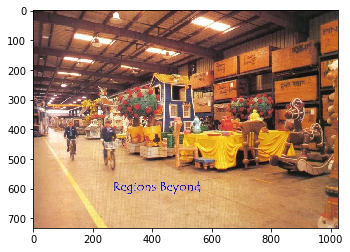

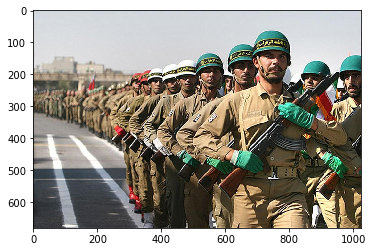

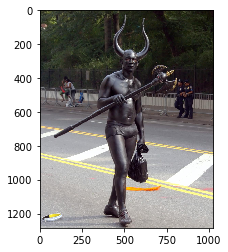

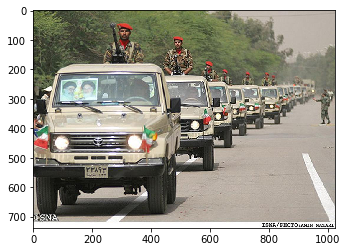

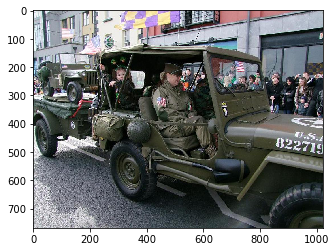

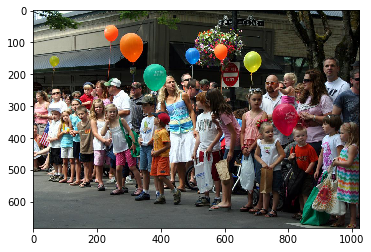

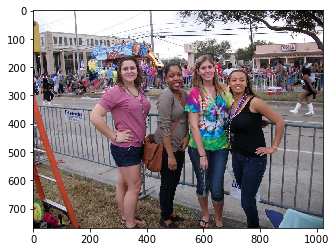

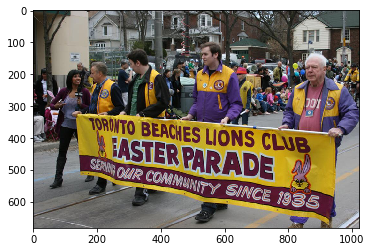

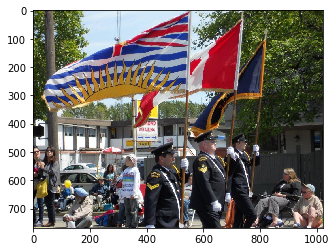

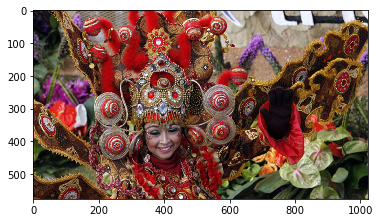

In [9]:
import matplotlib.pyplot as plt

# Inference images
for i in range(10):
    if transform_flag:
        plt.imshow(inf_dataset[i][0].numpy().transpose((1,2,0)), interpolation='nearest')
        plt.show()
    else:
        plt.imshow(inf_dataset[i][0])
        plt.show()

- Show images (video)

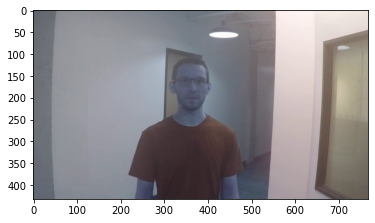

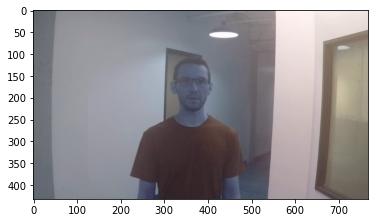

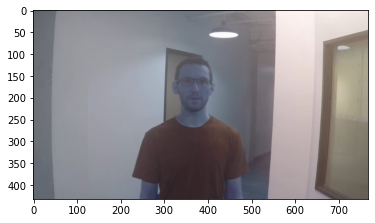

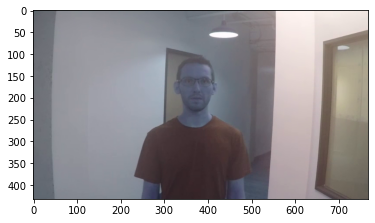

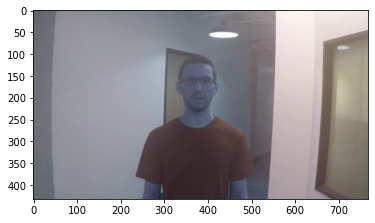

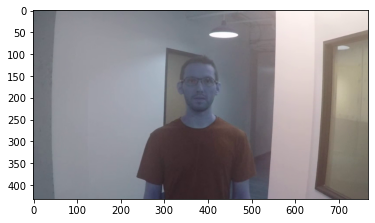

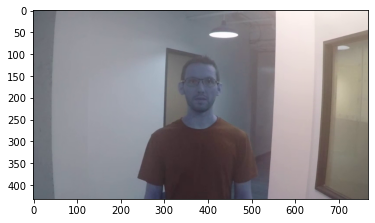

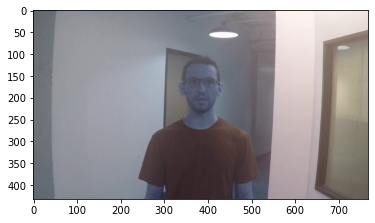

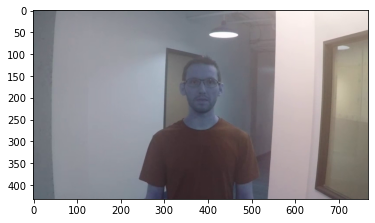

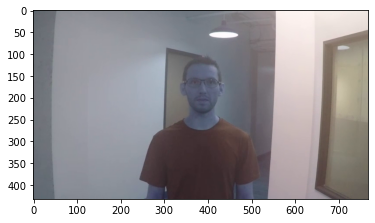

In [10]:
import matplotlib.pyplot as plt

# Inference images
for i in range(100,110):
    if transform_flag:
        plt.imshow(video_array[i])
        plt.show()
    else:
        plt.imshow(video_array[i])
        plt.show()

## - Face Tracking using pretrained FaceNet

In [11]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import PIL
from PIL import Image, ImageDraw
import numpy as np
import os

- Cuda or not

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.devicecu("cpu")
print(device)

cuda


- Load pretrained model

In [13]:
mtcnn = MTCNN(keep_all=True, device=device)

### - Images

- Inferene (detecting faces)

In [14]:
def inference():
    frames_tracked = []
    coordinates_list = []
    detection_file_path_list = []
    not_detection_file_path_list = []
    ori_frame_list = []

    for i, t in enumerate(inf_dataset):
        if i % 100 == 0:
            print('\rTracking frame: {}'.format(i + 1))
        if i == max_inf_num:
            break
        
        if transform_flag:
            frame = t[0].numpy().transpose((1,2,0))
            frame = Image.fromarray((frame * 255).astype(np.uint8))
        else:
            frame = t[0]
        
        file_path = t[2]

        # Detect faces
        boxes, _ = mtcnn.detect(frame)

        # Draw faces
        frame_draw = frame.copy()
        draw = ImageDraw.Draw(frame_draw)

        if not boxes is None:
            for box in boxes:
                draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)

            # Add to list
            detection_file_path_list.append(file_path)
            frames_tracked.append(frame_draw.resize(frame.size, Image.BILINEAR))
            coordinates_list.append(boxes)
            ori_frame_list.append(frame)
        else:
            not_detection_file_path_list.append(file_path)
    
    return frames_tracked, coordinates_list, detection_file_path_list, not_detection_file_path_list, ori_frame_list

frames_tracked_images, coordinates_list_images, detection_file_path_list, not_detection_file_path_list, ori_frame_list_images = inference()
print(len(detection_file_path_list))
print(len(not_detection_file_path_list))

Tracking frame: 1
Tracking frame: 101
Tracking frame: 201
Tracking frame: 301
Tracking frame: 401
Tracking frame: 501
484
16


(1024, 680)


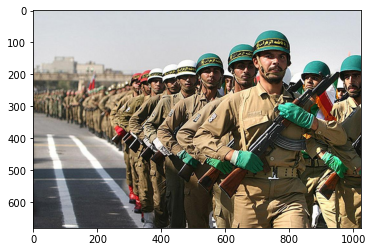

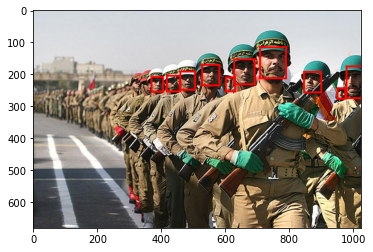

[[ 976.4645   173.13332 1072.7578   277.2061 ]
 [ 706.0353   113.87416  792.92676  215.86154]
 [ 625.94025  151.71046  694.2325   234.43634]
 [ 525.059    168.29865  584.99084  237.60385]
 [ 843.19     190.2956   902.6692   259.21863]
 [ 457.59412  189.99826  508.5434   251.79642]
 [ 415.99136  202.49605  461.7171   256.67084]
 [ 367.09476  206.31076  408.59927  257.09897]
 [ 599.41956  207.82274  633.58295  256.13077]
 [ 948.4983   241.56868  977.8517   279.2401 ]]
(1024, 1285)


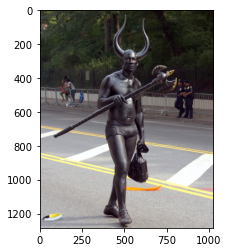

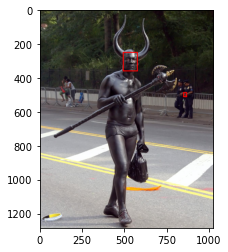

[[487.99142 247.4316  575.7118  361.20047]
 [842.81757 484.71783 865.3835  513.5707 ]]
(1024, 738)


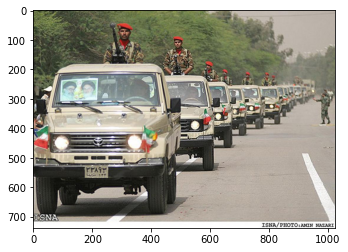

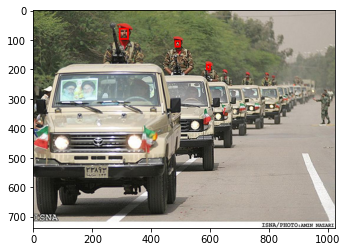

[[291.84744   60.300552 324.83392  100.121994]
 [480.46332  102.27986  500.56287  126.91054 ]
 [586.74615  182.496    602.6196   203.26721 ]]
(1024, 768)


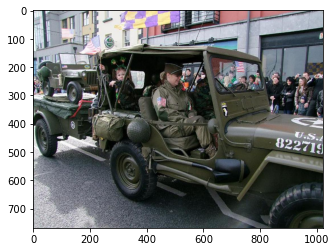

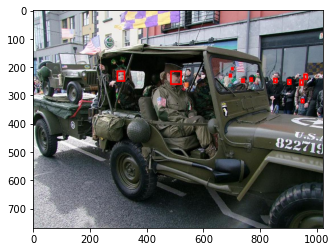

[[484.4031  213.62346 525.9828  263.32474]
 [295.2419  213.89528 325.24817 252.04755]
 [954.8575  224.17932 970.49445 246.07133]
 [940.79236 244.49004 955.90485 266.46762]
 [897.4306  243.05038 912.90765 263.30963]
 [848.68823 239.27585 863.51746 257.92377]
 [945.11676 312.9062  958.18774 328.57733]
 [735.7674  241.06729 747.97296 256.2532 ]
 [764.8403  237.05092 776.8549  252.45305]
 [691.6736  224.55872 702.36017 237.17755]
 [699.1136  201.46658 708.0446  212.96603]]
(1024, 683)


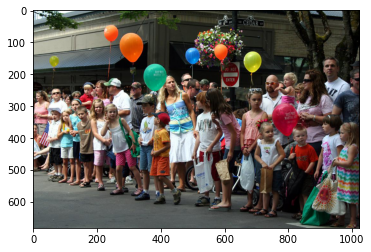

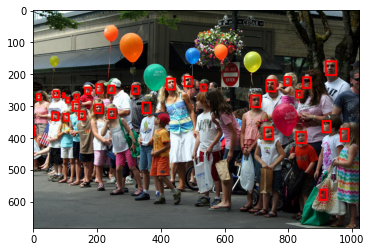

[[914.5713    158.36336   951.75464   206.65608  ]
 [821.0138    379.33255   856.0615    419.69806  ]
 [681.1786    265.30035   714.4302    306.22122  ]
 [721.7124    365.62994   754.2381    407.24884  ]
 [728.48456   217.9806    761.5811    257.8742   ]
 [961.25146   369.08292   990.5013    413.60315  ]
 [904.1372    345.11298   934.51996   385.02338  ]
 [416.86417   212.60033   447.34863   251.501    ]
 [-25.671757  360.19653     7.1703176 394.88583  ]
 [843.541     208.08311   872.3952    246.29483  ]
 [340.126     287.82886   369.0696    325.0763   ]
 [895.674     560.1344    923.8485    597.98785  ]
 [472.62598   206.74551   499.49304   241.1923   ]
 [234.49437   308.4492    260.8295    340.62354  ]
 [122.39395   285.7835    147.547     318.40225  ]
 [192.93352   293.48074   218.60262   325.29898  ]
 [785.44135   207.49765   809.52625   238.75221  ]
 [141.30429   315.17294   165.38869   345.65887  ]
 [307.53638   236.77617   332.3351    265.88388  ]
 [194.89182   230.14935   217.2

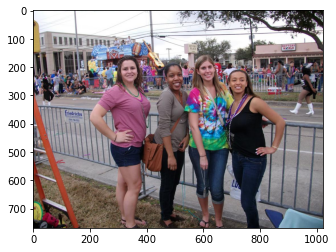

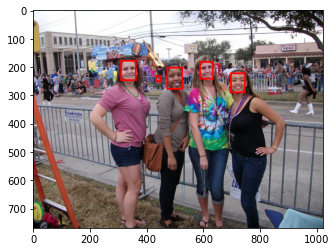

[[471.83298 200.30663 529.9216  280.67682]
 [308.86057 176.16472 365.39    249.98312]
 [696.602   220.35439 750.1415  292.48767]
 [587.1779  180.62619 637.43005 244.30042]
 [432.5694  230.89285 452.26498 253.88345]]
(1024, 683)


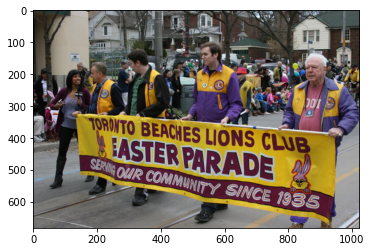

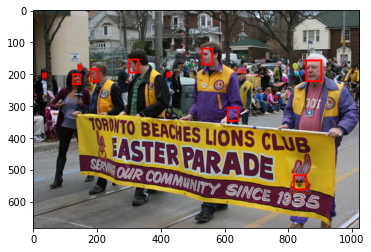

[[852.2088   155.00023  905.5111   225.05853 ]
 [814.3945   515.2907   857.0641   564.2543  ]
 [527.1083   118.32066  564.42365  172.44385 ]
 [607.05225  303.20868  645.9966   349.57895 ]
 [299.7599   152.38318  331.36395  198.64897 ]
 [178.1608   182.8899   206.13979  226.9026  ]
 [122.34226  198.8749   150.1395   234.3589  ]
 [ 28.600914 196.10483   42.383823 212.79866 ]
 [418.64548  193.85095  430.98938  211.86874 ]
 [140.0435   171.93587  152.5301   189.3634  ]]
(1024, 768)


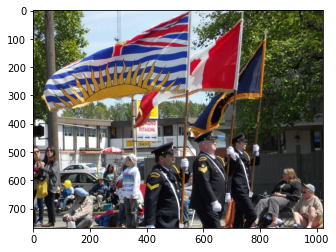

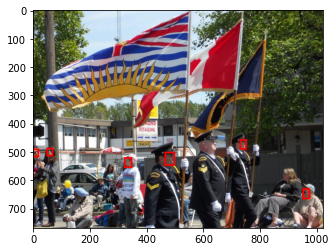

[[464.752     499.40472   501.4999    548.9907   ]
 [321.8274    518.54224   350.2677    556.6997   ]
 [951.70074   628.024     978.63434   666.0574   ]
 [729.0982    454.2556    754.7472    491.3956   ]
 [ -7.2658486 488.10828    21.15306   518.8367   ]
 [ 47.966812  485.78296    71.18486   515.37274  ]]
(1024, 576)


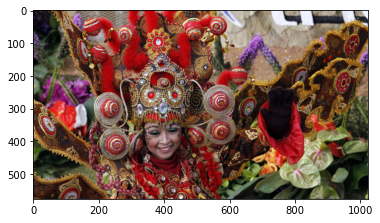

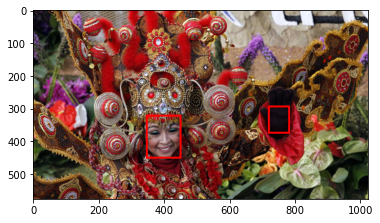

[[345.5375  319.4661  453.58444 452.281  ]
 [718.3111  291.42877 785.12335 376.04922]]
(1024, 683)


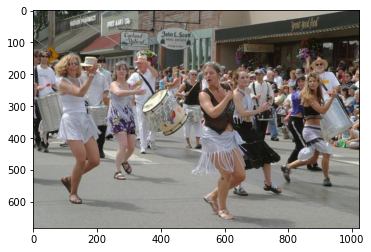

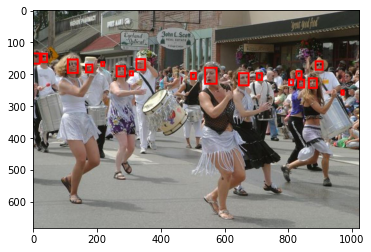

[[536.6941    178.364     577.16724   233.43092  ]
 [106.27624   152.27641   142.6338    199.70639  ]
 [642.94934   195.86522   677.9418    238.4956   ]
 [321.3312    151.15416   353.95255   189.318    ]
 [ -7.5443716 133.08577    23.969208  170.1799   ]
 [259.76746   173.88438   290.16394   210.9849   ]
 [861.49976   211.13928   891.0988    246.96167  ]
 [882.162     158.22777   909.8101    189.98126  ]
 [163.00552   168.0539    188.90898   197.74281  ]
 [827.44055   215.57799   851.9761    245.3984   ]
 [ 24.49786   134.51442    46.530876  165.14241  ]
 [698.53503   195.8988    719.0585    221.98196  ]
 [822.62463   189.42363   843.61255   214.11249  ]
 [492.6961    194.37328   512.2525    218.26631  ]
 [799.5344    215.95549   817.76465   237.4212   ]
 [300.41492   189.19502   315.58017   207.83691  ]
 [211.46457   160.86131   225.60727   177.73047  ]
 [963.5258    249.53926   975.4265    267.62378  ]]


In [15]:
for i in range(10):
    print(frames_tracked_images[i].size)
    plt.imshow(ori_frame_list_images[i])
    plt.show()
    plt.imshow(frames_tracked_images[i])
    plt.show()

    print(coordinates_list_images[i])

- Save images & coordinates of bounding boxes & original images

In [16]:
def write(frames_tracked, coordinates_list, detection_file_path_list, ori_frame_list):
    # Make folder
    if not os.path.exists('./face_boxing_images'):
        os.makedirs('./face_boxing_images')
    if not os.path.exists('./face_coordinates'):
        os.makedirs('./face_coordinates')
    if not os.path.exists('./ori_images'):
        os.makedirs('./ori_images')            
            
    # Save face boxing images
    for i, f in enumerate(frames_tracked):
        f.save('./face_boxing_images/' + detection_file_path_list[i].split('\\')[-1])

    # Save coordinates
    for i, cor in enumerate(coordinates_list):
        with open('./face_coordinates/' + detection_file_path_list[i].split('\\')[-1][:-3] + 'txt', mode='w') as file:
            for c in cor:
                file.write(str(c[0]) + ' ' + str(c[1]) + ' ' + str(c[2]) + ' ' + str(c[3]) + '\n')

    # Save original images 
    for i, f in enumerate(ori_frame_list):
        f.save('./ori_images/' + detection_file_path_list[i].split('\\')[-1])
        
write(frames_tracked_images, coordinates_list_images, detection_file_path_list, ori_frame_list_images)

### - Video

- Inferene (detecting faces)

In [17]:
def inference():
    frames_tracked = []
    coordinates_list = []
    ori_frame_list = []

    for i, t in enumerate(video_array):
        if i % 100 == 0:
            print('\rTracking frame: {}'.format(i + 1))
        if i == max_inf_num:
            break
        
        frame = t.transpose((0,1,2))
        frame = Image.fromarray((frame).astype(np.uint8))

        # Detect faces
        boxes, _ = mtcnn.detect(frame)

        # Draw faces
        frame_draw = frame.copy()
        draw = ImageDraw.Draw(frame_draw)

        if not boxes is None:
            for box in boxes:
                draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)

        # Add to list
        coordinates_list.append(boxes)
        frames_tracked.append(frame_draw.resize(frame.size, Image.BILINEAR))
        ori_frame_list.append(frame)
    
    return frames_tracked, coordinates_list, ori_frame_list, frame.size

frames_tracked_video, coordinates_list_video, ori_frame_list_video, video_size = inference()

Tracking frame: 1
Tracking frame: 101
Tracking frame: 201
Tracking frame: 301
Tracking frame: 401
Tracking frame: 501


(768, 432)


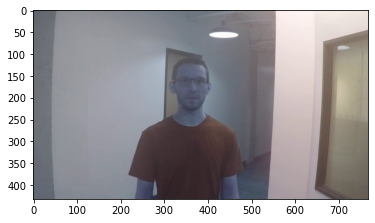

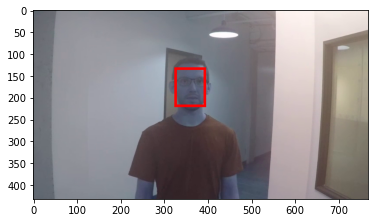

[[324.1911  131.9736  396.03925 221.5831 ]]
(768, 432)


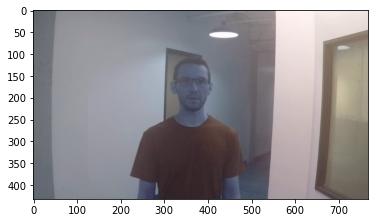

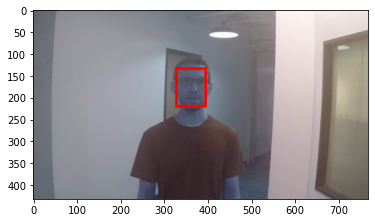

[[326.31915 131.56088 398.68607 222.66437]]
(768, 432)


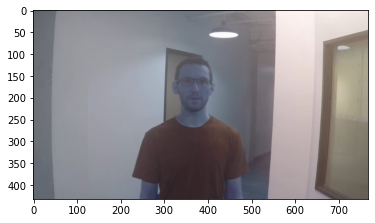

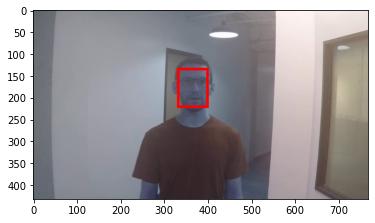

[[330.0758  132.95726 402.57596 223.42587]]
(768, 432)


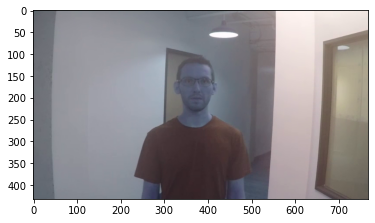

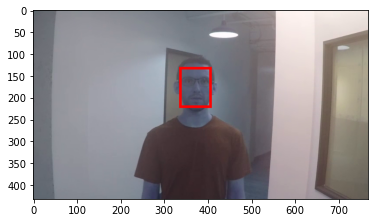

[[335.27844 130.14256 409.7256  223.08215]]
(768, 432)


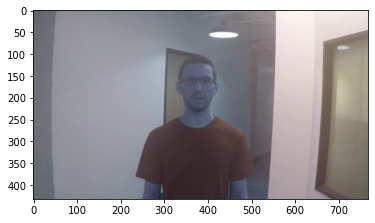

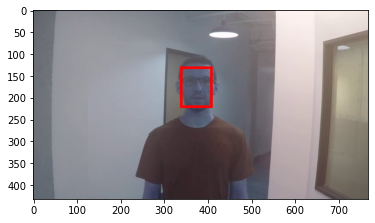

[[337.30862 129.23497 411.92596 223.10147]]
(768, 432)


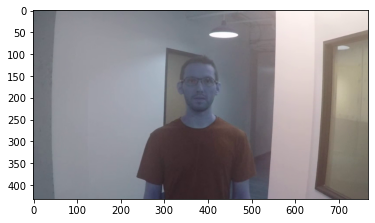

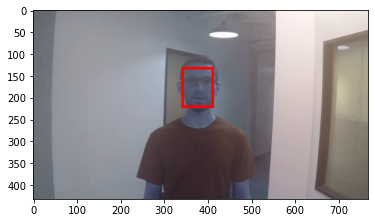

[[340.41464 130.29195 414.9339  223.61716]]
(768, 432)


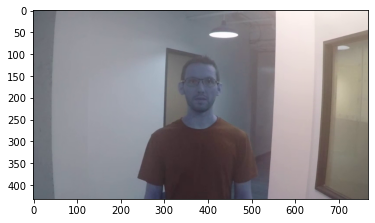

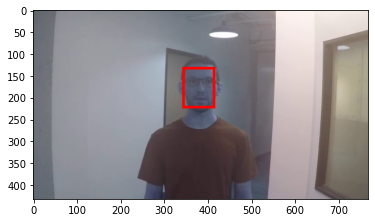

[[342.9601  130.8325  417.94675 224.17992]]
(768, 432)


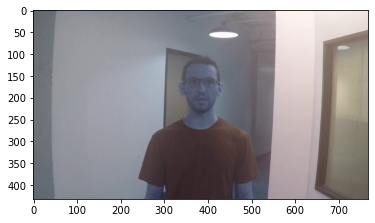

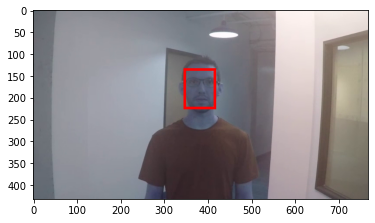

[[345.00034 133.49863 419.2089  226.12048]]
(768, 432)


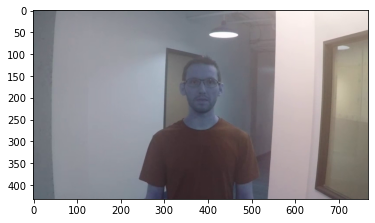

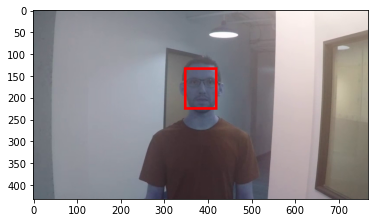

[[346.1428  131.81982 422.09738 227.2843 ]]
(768, 432)


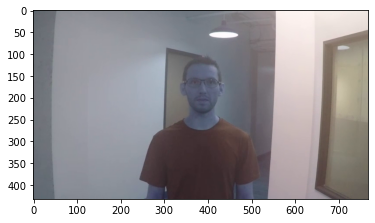

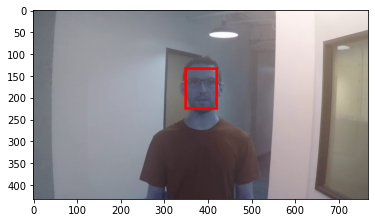

[[347.5439  131.23993 423.90692 227.43546]]


In [18]:
for i in range(100,110):
    print(frames_tracked_video[i].size)
    plt.imshow(ori_frame_list_video[i])
    plt.show()
    plt.imshow(frames_tracked_video[i])
    plt.show()

    print(coordinates_list_video[i])

- Save video

In [19]:
print(video_size)
video = cv2.VideoWriter('./test.avi', cv2.VideoWriter_fourcc(*'DIVX'), fps, video_size)

for image in frames_tracked_video:
    image = np.asarray(image)

    video.write(image)

cv2.destroyAllWindows()
video.release()

(768, 432)
